# Evolver Loop 1 Analysis

## Current Situation
- **Best Score**: 164.09 (from greedy baseline)
- **Target Score**: 68.92
- **Gap**: 95.17 points (138% worse than target)

## Key Insight from Research
The evaluator correctly identified that we're starting from scratch when top kernels use pre-optimized CSVs that already score ~70-72.

## Analysis Goals
1. Understand the zaburo kernel's grid-based approach (scores 88.33)
2. Implement a better baseline using grid placement
3. Plan for ensemble strategy

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 30
scale_factor = Decimal('1e15')

print("Libraries loaded")

Libraries loaded


In [2]:
# Load and analyze the current baseline submission
baseline = pd.read_csv('/home/code/experiments/001_baseline/submission.csv')
print(f"Baseline submission shape: {baseline.shape}")
print(baseline.head(10))

Baseline submission shape: (20100, 4)
      id           x           y          deg
0  001_0   s0.056435  s-0.305079  s314.999998
1  002_0   s0.340626  s-0.261989  s346.663915
2  002_1   s0.002093   s0.119736   s40.667789
3  003_0   s0.340626  s-0.261989  s346.663915
4  003_1   s0.002093   s0.119736   s40.667789
5  003_2   s0.163598   s0.629075  s290.566178
6  004_0   s0.437512   s0.285729  s433.079933
7  004_1   s0.035371   s-0.02828  s127.083807
8  004_2  s-0.462876   s0.164748  s376.982196
9  004_3   s0.392345  s-0.221006  s223.019977


In [3]:
# Calculate score per N for the baseline
def strip_s(val):
    return float(str(val).replace('s', ''))

# Tree geometry
TX = np.array([0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125])
TY = np.array([0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5])

def score_group(xs, ys, degs):
    n = len(xs)
    if n == 0:
        return 0
    
    all_x, all_y = [], []
    for i in range(n):
        r = np.radians(degs[i])
        c, s = np.cos(r), np.sin(r)
        for j in range(len(TX)):
            X = c * TX[j] - s * TY[j] + xs[i]
            Y = s * TX[j] + c * TY[j] + ys[i]
            all_x.append(X)
            all_y.append(Y)
    
    side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
    return side * side / n

# Calculate scores for each N
baseline['N'] = baseline['id'].str.split('_').str[0].astype(int)
scores_per_n = {}

for n, group in baseline.groupby('N'):
    xs = group['x'].apply(strip_s).values
    ys = group['y'].apply(strip_s).values
    degs = group['deg'].apply(strip_s).values
    scores_per_n[n] = score_group(xs, ys, degs)

total_score = sum(scores_per_n.values())
print(f"Total baseline score: {total_score:.6f}")

Total baseline score: 164.089491


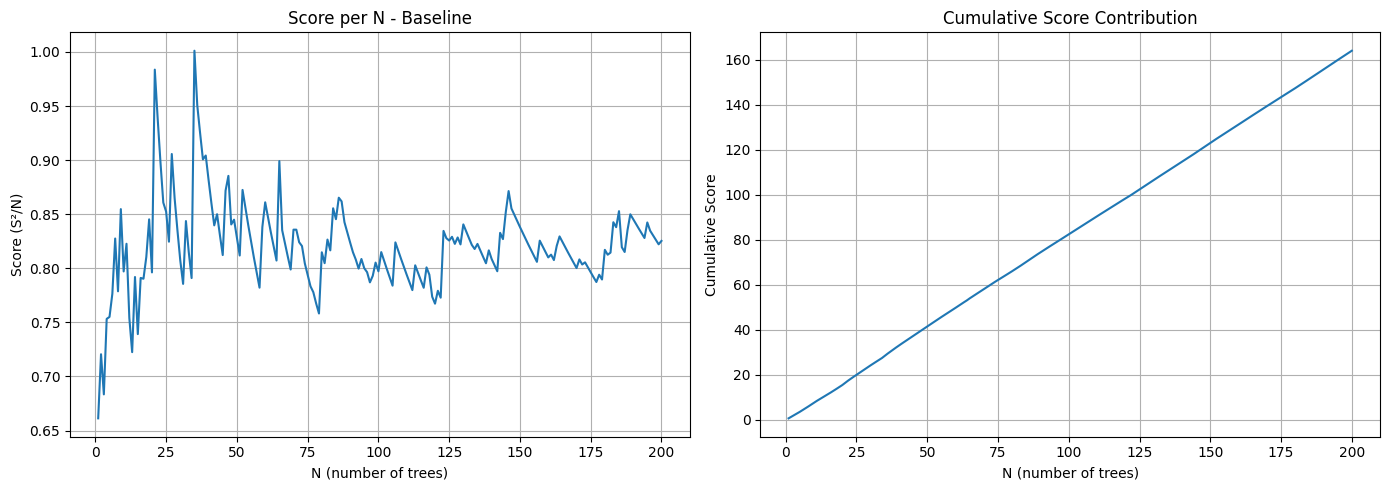


Score contribution by N range:
  N=1-50:   41.51 (25.3%)
  N=51-100: 40.97 (25.0%)
  N=101-150: 40.65 (24.8%)
  N=151-200: 40.97 (25.0%)


In [4]:
# Plot score distribution by N
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
ns = sorted(scores_per_n.keys())
scores = [scores_per_n[n] for n in ns]
plt.plot(ns, scores)
plt.xlabel('N (number of trees)')
plt.ylabel('Score (S²/N)')
plt.title('Score per N - Baseline')
plt.grid(True)

plt.subplot(1, 2, 2)
# Cumulative score contribution
cumulative = np.cumsum(scores)
plt.plot(ns, cumulative)
plt.xlabel('N (number of trees)')
plt.ylabel('Cumulative Score')
plt.title('Cumulative Score Contribution')
plt.grid(True)

plt.tight_layout()
plt.savefig('/home/code/exploration/score_distribution.png', dpi=100)
plt.show()

print(f"\nScore contribution by N range:")
print(f"  N=1-50:   {sum(scores[:50]):.2f} ({100*sum(scores[:50])/total_score:.1f}%)")
print(f"  N=51-100: {sum(scores[50:100]):.2f} ({100*sum(scores[50:100])/total_score:.1f}%)")
print(f"  N=101-150: {sum(scores[100:150]):.2f} ({100*sum(scores[100:150])/total_score:.1f}%)")
print(f"  N=151-200: {sum(scores[150:200]):.2f} ({100*sum(scores[150:200])/total_score:.1f}%)")

In [5]:
# Implement the zaburo grid-based approach
# This places trees in alternating rows with 0 and 180 degree rotations

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def find_best_trees_grid(n):
    """Zaburo's grid-based approach - alternating rows"""
    best_score, best_trees = float("inf"), None
    
    for n_even in range(1, n + 1):
        for n_odd in [n_even, n_even - 1]:
            if n_odd < 0:
                continue
            all_trees = []
            rest = n
            r = 0
            while rest > 0:
                m = min(rest, n_even if r % 2 == 0 else n_odd)
                if m <= 0:
                    break
                rest -= m
    
                angle = 0 if r % 2 == 0 else 180
                x_offset = 0 if r % 2 == 0 else Decimal("0.7") / 2
                y = r // 2 * Decimal("1.0") if r % 2 == 0 else (Decimal("0.8") + (r - 1) // 2 * Decimal("1.0"))
                row_trees = [ChristmasTree(center_x=Decimal("0.7") * i + x_offset, center_y=y, angle=angle) for i in range(m)]
                all_trees.extend(row_trees)
    
                r += 1
            
            if len(all_trees) != n:
                continue
                
            xys = np.concatenate([np.asarray(t.polygon.exterior.xy).T / 1e15 for t in all_trees])
    
            min_x, min_y = xys.min(axis=0)
            max_x, max_y = xys.max(axis=0)

            score = max(max_x - min_x, max_y - min_y) ** 2
            if score < best_score:
                best_score = score
                best_trees = all_trees
    
    return best_score, best_trees

print("Grid placement function defined")

Grid placement function defined


In [6]:
# Test the grid approach on a few N values
test_ns = [10, 50, 100, 150, 200]

for n in test_ns:
    score, trees = find_best_trees_grid(n)
    print(f"N={n:3d}: Grid score = {score:.6f}, Score/N = {score/n:.6f}")

N= 10: Grid score = 4.840000, Score/N = 0.484000


N= 50: Grid score = 24.010000, Score/N = 0.480200


N=100: Grid score = 39.690000, Score/N = 0.396900


N=150: Grid score = 64.000000, Score/N = 0.426667


N=200: Grid score = 81.000000, Score/N = 0.405000


In [7]:
# Calculate total score for grid approach
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import multiprocessing

# Use single-threaded for now to avoid issues
print("Calculating grid scores for all N...")
grid_scores = {}
for n in range(1, 201):
    score, _ = find_best_trees_grid(n)
    grid_scores[n] = score / n  # Score contribution is S²/N
    if n % 20 == 0:
        print(f"  N={n}: {score/n:.6f}")

total_grid_score = sum(grid_scores.values())
print(f"\nTotal grid score: {total_grid_score:.6f}")
print(f"Baseline score:   {total_score:.6f}")
print(f"Improvement:      {total_score - total_grid_score:.6f}")

Calculating grid scores for all N...


  N=20: 0.496125


  N=40: 0.441000


  N=60: 0.450667


  N=80: 0.442531


  N=100: 0.396900


  N=120: 0.408333


  N=140: 0.385875


  N=160: 0.405016


  N=180: 0.392000


  N=200: 0.405000

Total grid score: 88.329998
Baseline score:   164.089491
Improvement:      75.759493


In [8]:
# Compare with target
target = 68.922808
print(f"\nScore Comparison:")
print(f"  Baseline (greedy):  {total_score:.6f}")
print(f"  Grid approach:      {total_grid_score:.6f}")
print(f"  Target:             {target:.6f}")
print(f"\nGap to target:")
print(f"  From baseline: {total_score - target:.6f} ({100*(total_score - target)/target:.1f}% worse)")
print(f"  From grid:     {total_grid_score - target:.6f} ({100*(total_grid_score - target)/target:.1f}% worse)")


Score Comparison:
  Baseline (greedy):  164.089491
  Grid approach:      88.329998
  Target:             68.922808

Gap to target:
  From baseline: 95.166683 (138.1% worse)
  From grid:     19.407190 (28.2% worse)
